In [12]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo
from M1_util_train_test import load_model, test
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
load_model_file = 'sae'
model_code = 'A'
zoomlevel = 'zoom13_bilateral'
output_dim = 1
model_run_date = '220115'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

# Load Model Embeddings

In [62]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [63]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Trip Behavior

In [5]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, unique_ct)

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()
# train_test_index = np.random.rand(len(df_pivot)) < 0.2

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [64]:
x_train = aggregate_embeddings[~train_test_index, :]
x_test = aggregate_embeddings[train_test_index, :]

# MNL for Mode Share

In [65]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=True)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [66]:
wd_list = [0.00005,0.0001,0.0005,0.001]
lr_list = [0.005, 0.01]

for (lr, wd) in itertools.product(lr_list, wd_list):
    # model setup
    model = mnl.MNL(n_alts=4, n_features=x_train.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # model training

    ref1 = 0
    ref2 = 0

    for epoch in range(400):

        kl_ = 0
        mse_ = 0
        mse1_ = 0
        mse2_ = 0
        mse3_ = 0
        mse4_ = 0

        for batch, (x_batch, y_batch) in enumerate(trainloader):
            # Compute prediction and loss
            util = model(x_batch)
            probs = torch.log(nn.functional.softmax(util, dim=1))
            kl = kldivloss(probs, y_batch)
    #         kl = kldivloss(torch.log(util), y_batch)
            kl_ += kl.item()

            mse = mseloss(torch.exp(probs), y_batch)
    #         mse = mseloss(util, y_batch)
            mse_ += mse.sum().item()
            mse1_ += mse[:,0].sum().item()
            mse2_ += mse[:,1].sum().item()
            mse3_ += mse[:,2].sum().item()
            mse4_ += mse[:,3].sum().item()
            mse = mse.sum()

            # Backpropagation
            optimizer.zero_grad()
            kl.backward()
            optimizer.step()

        train_kl = kl_/len(trainset)
        train_mse = np.sqrt(mse_/len(trainset))
        train_mse1 = np.sqrt(mse1_/len(trainset))
        train_mse2 = np.sqrt(mse2_/len(trainset))
        train_mse3 = np.sqrt(mse3_/len(trainset))
        train_mse4 = np.sqrt(mse4_/len(trainset))

        if epoch % 10 == 0:
            print(f"[epoch: {epoch:>2d}] Train KL loss: {train_kl:.3f} \
                RMSE {train_mse:.3f} \
                {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
        loss_ = train_kl

        if epoch % 5 == 0:
            if epoch > 50:
                if (np.abs(loss_ - ref1)/ref1<ref1*0.01) & (np.abs(loss_ - ref2)/ref2<ref2*0.01):
                    print("Early stopping at epoch", epoch)
                    break
                if (ref1 < loss_) & (ref1 < ref2):
                    print("Diverging. stop.")
                    break
                if loss_ < best:
                    best = loss_
                    best_epoch = epoch
            else:
                best = loss_
                best_epoch = epoch

            ref2 = ref1
            ref1 = loss_

        if epoch % 10 == 0:

            kl_ = 0
            mse_ = 0 
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(testloader):
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util,dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()

            test_kl = kl_/len(testset)
            test_mse = np.sqrt(mse_/len(testset))
            test_mse1 = np.sqrt(mse1_/len(testset))
            test_mse2 = np.sqrt(mse2_/len(testset))
            test_mse3 = np.sqrt(mse3_/len(testset))
            test_mse4 = np.sqrt(mse4_/len(testset))

            r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
            r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
            r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
            r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

            print(f"[epoch: {epoch:>2d}] Test KL loss: {kl_/len(testset):.3f}\
                    RMSE {np.sqrt(mse_/len(testset)):.3f} \
                    {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
            print(f"\t\t\t\t\t\t\tR2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")


    with open(out_dir+model_code+"_mode_choice.csv", "a") as f:
        f.write("%s,%s,%s,%s,%.4f,%d,%.5f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
            (model_run_date, model_type, zoomlevel, "MNL", lr, -1, wd, 
              train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
              test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
              r1, r2, r3, r4))

[epoch:  0] Train KL loss: 0.660                 RMSE 0.596                 0.196 0.496 0.187 0.188
[epoch:  0] Test KL loss: 0.299                    RMSE 0.360                     0.177 0.276 0.096 0.115
							R2 score: -0.001 -0.227 -5.758 -0.305 
[epoch: 10] Train KL loss: 0.129                 RMSE 0.212                 0.124 0.151 0.053 0.062
[epoch: 10] Test KL loss: 0.219                    RMSE 0.307                     0.178 0.230 0.037 0.091
							R2 score: -0.010 0.149 -0.014 0.181 
[epoch: 20] Train KL loss: 0.110                 RMSE 0.193                 0.114 0.136 0.053 0.053
[epoch: 20] Test KL loss: 0.203                    RMSE 0.297                     0.167 0.224 0.037 0.093
							R2 score: 0.110 0.188 -0.024 0.142 
[epoch: 30] Train KL loss: 0.105                 RMSE 0.188                 0.110 0.133 0.052 0.052
[epoch: 30] Test KL loss: 0.205                    RMSE 0.298                     0.166 0.225 0.038 0.095
							R2 score: 0.119 0.182 -0.044 0.100 


[epoch: 70] Train KL loss: 0.098                 RMSE 0.179                 0.104 0.126 0.052 0.050
[epoch: 70] Test KL loss: 0.204                    RMSE 0.296                     0.165 0.223 0.038 0.096
							R2 score: 0.136 0.195 -0.051 0.091 
[epoch: 80] Train KL loss: 0.097                 RMSE 0.177                 0.103 0.125 0.051 0.050
[epoch: 80] Test KL loss: 0.205                    RMSE 0.296                     0.164 0.224 0.038 0.096
							R2 score: 0.139 0.193 -0.049 0.083 
[epoch: 90] Train KL loss: 0.096                 RMSE 0.176                 0.102 0.124 0.051 0.050
[epoch: 90] Test KL loss: 0.205                    RMSE 0.296                     0.165 0.224 0.038 0.096
							R2 score: 0.137 0.194 -0.059 0.084 
[epoch: 100] Train KL loss: 0.095                 RMSE 0.174                 0.101 0.123 0.051 0.049
[epoch: 100] Test KL loss: 0.204                    RMSE 0.295                     0.164 0.223 0.038 0.096
							R2 score: 0.144 0.201 -0.068 0.088 
[e

[epoch: 40] Train KL loss: 0.099                 RMSE 0.180                 0.105 0.127 0.052 0.050
[epoch: 40] Test KL loss: 0.204                    RMSE 0.296                     0.165 0.223 0.038 0.096
							R2 score: 0.137 0.197 -0.057 0.088 
[epoch: 50] Train KL loss: 0.097                 RMSE 0.177                 0.103 0.125 0.051 0.050
[epoch: 50] Test KL loss: 0.205                    RMSE 0.297                     0.165 0.224 0.038 0.096
							R2 score: 0.128 0.188 -0.052 0.094 
[epoch: 60] Train KL loss: 0.096                 RMSE 0.175                 0.102 0.124 0.051 0.049
[epoch: 60] Test KL loss: 0.205                    RMSE 0.296                     0.164 0.224 0.038 0.096
							R2 score: 0.140 0.192 -0.052 0.083 
[epoch: 70] Train KL loss: 0.094                 RMSE 0.173                 0.101 0.122 0.051 0.049
[epoch: 70] Test KL loss: 0.209                    RMSE 0.299                     0.166 0.226 0.038 0.096
							R2 score: 0.118 0.177 -0.068 0.086 
[epo

[epoch: 40] Train KL loss: 0.099                 RMSE 0.181                 0.106 0.127 0.052 0.050
[epoch: 40] Test KL loss: 0.209                    RMSE 0.301                     0.168 0.228 0.038 0.096
							R2 score: 0.104 0.163 -0.032 0.086 
[epoch: 50] Train KL loss: 0.097                 RMSE 0.177                 0.103 0.125 0.051 0.050
[epoch: 50] Test KL loss: 0.206                    RMSE 0.297                     0.165 0.224 0.039 0.096
							R2 score: 0.133 0.194 -0.083 0.084 
[epoch: 60] Train KL loss: 0.096                 RMSE 0.175                 0.102 0.124 0.051 0.049
[epoch: 60] Test KL loss: 0.204                    RMSE 0.295                     0.164 0.222 0.038 0.096
							R2 score: 0.143 0.202 -0.073 0.095 
[epoch: 70] Train KL loss: 0.094                 RMSE 0.174                 0.101 0.122 0.051 0.049
[epoch: 70] Test KL loss: 0.203                    RMSE 0.294                     0.163 0.221 0.039 0.096
							R2 score: 0.155 0.211 -0.085 0.088 
[epo

(0, 1)

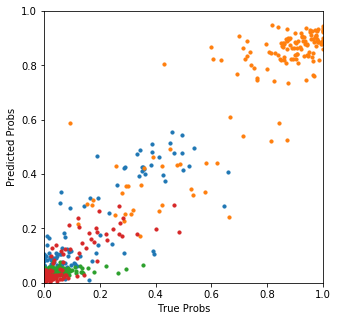

In [67]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1])


# Linear Regression / Logistic Regression for Mode Choice

0.03861788072428318 0.05915592752590282 -0.015364276970998736 0.04173291554608982


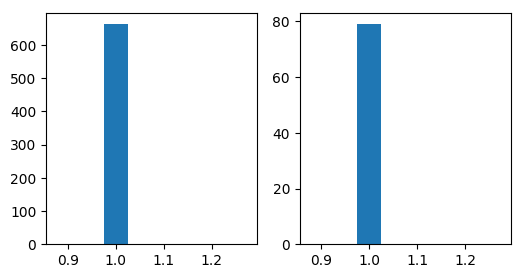

In [36]:
model = "LR"
# 1->L1; 0->L2
regularization = 0
reg_parameter = 2

fig, ax = plt.subplots(1, 4, figsize=(20,4))

pred_train = []
pred_test = []
train_mse_lr = []
train_r_lr = []
test_mse_lr = []
test_r_lr = []

for i in range(4):

    y_train_lr = y[~train_test_index,i]
    y_test_lr = y[train_test_index,i]

    if model == "LR":
    # Normal Linear Regression
        lr = linear_model.Ridge(alpha=reg_parameter)
        lr.fit(x_train, y_train_lr)

    elif model == "GLM":
    # GLM with logit link (ensure probs are \in [0,1])
        lr = sm.GLM(y_train_lr, x_train, family=sm.families.Binomial())
        lr = lr.fit_regularized(alpha=reg_parameter, L1_wt=regularization)
    else:
        print("ERROR")
        break
        
    ax[i].scatter(y_train_lr, lr.predict(x_train), s=5)
    ax[i].scatter(y_test_lr, lr.predict(x_test), s=5)
    ax[i].plot([0, max(y_train_lr)],[0, max(y_train_lr)])

    pred_train.append(lr.predict(x_train))
    pred_test.append(lr.predict(x_test)) 

    train_mse_lr.append(np.sqrt(mean_squared_error(lr.predict(x_train), y_train_lr)))
    train_r_lr.append(r2_score(y_train_lr, lr.predict(x_train)))
    test_mse_lr.append(np.sqrt(mean_squared_error(lr.predict(x_test), y_test_lr)))
    test_r_lr.append(r2_score(y_test_lr, lr.predict(x_test)))

pred_train = np.array(pred_train).T
pred_test = np.array(pred_test).T

train_mse = np.sqrt(mean_squared_error(pred_train, y[~train_test_index,:4]))
test_mse = np.sqrt(mean_squared_error(pred_test, y[train_test_index,:4]))

# the entropy function will normalize the probabilities
# not suitable for probabilities gotten from linear regression and GLM

# train_kl = entropy(y[~train_test_index,:4], pred_train, axis=1).mean()
# test_kl = entropy(y[train_test_index,:4], pred_test, axis=1).mean()

print(test_r_lr[0], test_r_lr[1], test_r_lr[2], test_r_lr[3])
                                                                                                     
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].hist(pred_train.sum(axis=1), bins = np.linspace(0.875, 1.275, 9))
ax[1].hist(pred_test.sum(axis=1), bins = np.linspace(0.875, 1.275, 9));
fig 



In [37]:
with open(out_dir+model_code+"_mode_choice.csv", "a") as f:
    f.write("%s,%s,%s,%s,%d,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
                      (model_run_date, model_type, zoomlevel, model, regularization, reg_parameter,
                      -1, train_mse, train_mse_lr[0], train_mse_lr[1], train_mse_lr[2], train_mse_lr[3],
                      -1, test_mse, test_mse_lr[0], test_mse_lr[1], test_mse_lr[2], test_mse_lr[3],
                      test_r_lr[0], test_r_lr[1], test_r_lr[2], test_r_lr[3])) 
 

# LR for trip generation

In [38]:
trpgen_train =  y[~train_test_index,1]
trpgen_test =  y[train_test_index,1]

In [39]:
lr = linear_model.LinearRegression()
lr.fit(x_train, trpgen_train)
with open(out_dir+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
    f.write("%s,%s,%s,%.4f,,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], -1, 
        lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test), 'lr', zoomlevel,
        np.sum(lr.coef_ != 0), len(lr.coef_)))
print(lr.score(x_train, trpgen_train), lr.score(x_test, trpgen_test))

0.9999977559361426 -1.1354757925689754


In [40]:
for a in np.linspace(0.005, 0.014, 10):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    with open(out_dir+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
        f.write("%s,%s,%s,%.6f,,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
            lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', zoomlevel,
            np.sum(lasso.coef_ != 0), len(lasso.coef_)))
    print(lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test))

-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957
-5.595524044110789e-14 -0.022658976492462957


In [41]:
for a in np.linspace(1,4,10):
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, trpgen_train)
    with open(out_dir+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
        f.write("%s,%s,%s,%.4f,,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
            ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
            np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print(ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test))

0.34874319703756884 0.09794299931801165
0.30471725338388667 0.08127266568118652
0.2706321656368852 0.06884692964830619
0.24341074185642464 0.05915592752590282
0.22115700177747188 0.05135860168579243
0.20262236958808044 0.04493742259766953
0.18694648787762935 0.03955192198670132
0.1735159951352866 0.03496739198629484
0.1618813615704915 0.03101582568258443
0.15170552372717627 0.02757388114271553
